In [228]:
import os
import harpy as hp

data_path = "/Users/arnedf/VIB/DATA/hubmap"

file = "Segmented_Bronchi_TMA_Scan1.er.qptiff"

input_path = os.path.join( data_path, file )

In [3]:
from contextlib import contextmanager
from typing import Generator
from xml.etree import ElementTree

import dask.array as da
import ome_types
from ome_types.model import UnitsLength
import tifffile

# Class for basic Tiff and QPTiff file reading.

class Tiff:
    """ Class for reading TIFF and QPTIFF files. """
    def __init__(self, filepath):
        self.filepath = filepath
        self.tif = None
        self.pages = []
        self.channel_names = []
        self.pixel_size_um = None

    def open(self):
        """ Open the file for reading """
        self.tif = tifffile.TiffFile(self.filepath)
        self.pages = self.tif.series[0].pages
        self.channel_names = self._get_channel_names()
        self.pixel_size_um = self._get_pixel_size_um()

    def close(self):
        """ Close the file """
        if self.tif:
            self.tif.close()

    def __enter__(self):
        self.open()
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.close()

    def read_channel(self, name):
        """ Read the channel with the given name from the tiff/qptiff file and
            return the pixel data as a numpy array. """
        idx = self.channel_names.index(name)
        return self.pages[idx].asarray()
    
    @contextmanager
    def dask_array(self) -> Generator[da.Array, None, None]:
        """ Read the full tiff/qptiff file into a dask array of dimensions (c, y, x). """

        # Represent each channel of the TIFF file as a zarr store (a tifffile.ZarrTiffStore).
        # No temporary zarr files on disk are created. Instead, when the zarr store is accessed,
        # the tifffile library will read the pixel data from the underlying existing tiff file.
        # Dask arrays are then created from these zarr stores.
        # This proces is lazy and almost instantaneous.
        zarr_stores = []
        dask_arrays = []
        for channel in range(len(self.channel_names)):
            zarr_store = tifffile.imread(self.filepath, key=channel, aszarr=True)
            zarr_stores.append(zarr_store)
            dask_array = da.from_zarr(zarr_store)
            dask_arrays.append(dask_array)

        # Combine dask arrays for each channel into a single dask array.
        full_dask_image = da.stack(dask_arrays)
        yield full_dask_image

        # Close all ZarrTiffStore's
        for zarr_store in zarr_stores:
            zarr_store.close()

    def _get_channel_names(self):
        if self.pages.kind.lower() == 'qpi':
            # It's a PerkinElmer qptiff, for example from a VectraPolaris scanner.
            # These apparently do not have OME metadata, but store metadata in a 
            # description tag per channel image. 
            # The name of fluorophore is stored in the "Name" tag. More recent versions
            # of the file format have an additional "Biomarker" tag that stores the
            # detected molecule (e.g. Ki67, Podoplanin, ...). If present we will use the biomarker
            # as channel name, otherwise the fluorophore name.
            # See also the bioformats VectroPolaris qptiff reader:
            # https://github.com/ome/bioformats/blob/develop/components/formats-gpl/src/loci/formats/in/VectraReader.java
            # and the Akoya PhenoChart user guide (appendix B): https://www.akoyabio.com/wp-content/uploads/PhenochartUserManual_2_2_0_rev0.pdf
            channel_names = []
            for page in self.pages:
                description = ElementTree.fromstring(page.description)
                
                image_type = description.find('ImageType').text
                assert image_type == "FullResolution"

                biomarker_tag = description.find('Biomarker')
                if biomarker_tag is not None:
                    channel_name = biomarker_tag.text
                else:
                    name_tag = description.find('Name')
                    if name_tag is not None:
                        channel_name = name_tag.text
                    else:
                        channel_name = None
                channel_names.append(channel_name)
            return channel_names
        elif self.pages.kind.lower() == 'ome':
            # If the qptiff has OME metadata (like Lunaphore COMET)
            # read it from the OME XML tag.
            xml = tifffile.tiffcomment(self.filepath)
            assert xml
            ome = ome_types.from_xml(xml)
            assert len(ome.images) == 1
            channel_names = [channel.name for channel in ome.images[0].pixels.channels]
            return channel_names
        elif self.pages.kind.lower() == 'imagej':
            # ImageJ compatible TIFFs have yet another way to store metadata.
            # The channel names are stored under the "Labels" key in this dict.
            return self.tif.imagej_metadata['Labels']
        else:
            return []

    # def _get_pixel_size_um(self):
    #     page = self.pages[0]  # pick the first channel, the resolution of all channels is assumed to be identical
    #     scale = 1000000 if page.tags['ResolutionUnit'].value == tifffile.RESUNIT.NONE else None  # ImageJ compatible TIFFs (sometimes?) don't specify the ResolutionUnit tag, but assume micrometers
    #     resolution = page.get_resolution(tifffile.RESUNIT.MICROMETER, scale=scale)
    #     assert resolution[0] == resolution[1], "(qp)tiff x and y resolution are not the same"
    #     pixelsize = 1 / resolution[0]
    #     return pixelsize
    
    def _get_pixel_size_um(self) -> float | None:
        # If the TIFF file is an OME TIFF, and the OME XML tag specifies a physical size, then return this value
        if self.tif.is_ome:
            pixelsize = self._ome_get_physical_size_x_um()
            if pixelsize is not None:
                return pixelsize
            
        # If the file is not OME, or the OME XML file did not specify a pixelsize,
        # then attempt to get it from the regular TIFF metadata tags.
        page = self.pages[0]  # pick the first channel, the resolution of all channels is assumed to be identical
        unit = page.tags['ResolutionUnit'].value
        if unit == tifffile.RESUNIT.NONE:
            return None  # if it's an ImageJ TIFF file, we could check TiffTag 270 ImageDescription, which may contain a units specification, but for now we simply don't support this case. Neither does QuPath, it seems.
        resolution = page.get_resolution(tifffile.RESUNIT.MICROMETER)
        assert resolution[0] == resolution[1], "(qp)tiff x and y resolution are not the same"
        pixelsize = 1 / resolution[0]
        return pixelsize
        
        
    def _ome_get_physical_size_x_um(self) -> float | None:
        assert self.tif.is_ome
        ome_xml = self.tif.ome_metadata
        ome = ome_types.from_xml(ome_xml, validate=False)
        pixels = ome.images[0].pixels
        size = pixels.physical_size_x
        if size is None:
            return None
        match pixels.physical_size_x_unit:
            case UnitsLength.NANOMETER:
                return size / 1000.0
            case UnitsLength.MICROMETER:
                return size
            case UnitsLength.MILLIMETER:
                return size * 1000.0
            case UnitsLength.CENTIMETER:
                return size * 10000.0
            case _:
                assert False, f"OME unit {pixels.physical_size_x_unit} is not supported"

    # Note about tiff/qptiff pages:
    # - TiffFile.pages[] has *all* the images in the qptiff file,
    #   including the different lower-resolution levels in the image pyramid,
    #   the overview and thumbnail images etc.
    # - TiffFile.series[0].pages[] on the other hand only stores the full resolution
    #   images with the actual image data, which is exactly what we need.

In [229]:
zarr_path = os.path.join( data_path, "sdata_phenocycler.zarr" )

with Tiff(input_path) as tif:
    channel_names = tif.channel_names
    pixel_size_um = tif.pixel_size_um

with Tiff(input_path) as tif:
           with tif.dask_array() as dask_img:        
               hp.io.create_sdata(
                   dask_img,
                   dims=['c', 'y', 'x'],
                   output_path=zarr_path,
                   img_layer="scan",
                   chunks=2048,
                   scale_factors=[2, 2, 2, 2, 2],
                   c_coords=tif.channel_names
               )

ValueError: The Zarr store already exists. Use `overwrite=True` to try overwriting the store. Please note that only Zarr stores not currently in use by the current SpatialData object can be overwritten.

In [235]:
import os
from spatialdata import read_zarr

sdata=read_zarr( os.path.join( data_path, "sdata_phenocycler.zarr" ))

We crop out each region, and save each one separately in its own coordinate space:

- read in the polygons that define each region
- rasterize the polygons (creation of the corresponding mask)
- extract the region

In [236]:
import geopandas as gpd
from spatialdata.transformations import Translation
from harpy.image._image import _get_spatial_element

tma_2_1_2 = "D231-RLL-14C2-HM-TMA-2-1-2.geojson" # region 1
tma_2_2_2 = "D239-RLL-19C2-HM-TMA-2-2-2.geojson" 
tma_2_3_2 = "D260-RLL-12C2-HM-TMA-2-3-2.geojson" # region 3
tma_2_4_2 = "D264-LLL-11C1-HM-TMA-2-4-2.geojson" # region 4
tma_2_5_2 = "D264-LLL-11C2-HM-TMA-2-5-2.geojson"
tma_2_6_2 = "D265-RLL-10C2-HM-TMA-2-6-2.geojson" # region 6
tma_2_7_2 = "D271-RLL-13D4-HM-TMA-2-7-2.geojson" # region 7
tma_2_8_2 = "D292-RLL-14C3-HM-TMA-2-8-2.geojson" 
tma_2_9_2 = "D341-RLL-14C2-HM-TMA-2-9-2.geojson"
tma_2_10_2 = "D346-RLL-17C3-HM-TMA-2-10-2.geojson" # region 10

tma_paths = [ tma_2_1_2, tma_2_2_2, tma_2_3_2, tma_2_4_2, tma_2_5_2, tma_2_6_2, tma_2_7_2, tma_2_8_2, tma_2_9_2, tma_2_10_2 ]
tma_name =  [ "region1", "region2", "region3", "region4", "region5", "region6", "region7", "region8", "region9", "region10" ]

se_image = _get_spatial_element( sdata, layer = "scan" )

for _tma_path, _tma_name in zip(tma_paths, tma_name, strict=True):

    # Read the GeoJSON file
    gdf = gpd.read_file( os.path.join( data_path, _tma_path ) )
    gdf.index = gdf.index +1
    sdata = hp.sh.add_shapes_layer( sdata, input=gdf, output_layer=_tma_name, overwrite=True )

    # rasterize the shapes layer
    sdata = hp.im.rasterize(
        sdata,
        shapes_layer=_tma_name,
        output_layer=f"{_tma_name}_labels",
        out_shape= se_image.shape[ 1: ],
        chunks = 2048,
        overwrite=True,
        scale_factors=[ 2,2,2,2,2 ],
        )
    
    se_mask = _get_spatial_element(sdata, layer=f"{_tma_name}_labels" )

    mask = se_mask.data
    image = se_image.data

    mask = mask[None, ...]

    # create a mask
    masked_image = da.where(mask == 1, image, 0)

    x_min, y_min, x_max, y_max = sdata[ _tma_name ].geometry.total_bounds.astype( int )

    translation = Translation( translation=[x_min, y_min], axes = ("x", "y") )

    masked_image = masked_image[ :, y_min: y_max, x_min: x_max ]

    sdata = hp.im.add_image_layer(
        sdata,
        arr = masked_image.rechunk( 2048 ),
        output_layer=f"scan_{_tma_name}",
        transformations={ _tma_name: translation },
        c_coords=se_image.c.data,
        overwrite=True,
        )

Skipping field color: unsupported OGR type: 1
2025-04-28 13:26:00,092 - harpy.utils._io - WARNING - layer with name 'region1' already exists. Overwriting...
2025-04-28 13:26:12,861 - harpy.image._manager - INFO - Writing results to layer 'region1_labels'
2025-04-28 13:26:15,543 - harpy.utils._io - WARNING - layer with name 'region1_labels' already exists. Overwriting...
2025-04-28 13:26:16,390 - harpy.image._manager - INFO - Writing results to layer 'scan_region1'
2025-04-28 13:26:22,991 - harpy.utils._io - WARNING - layer with name 'scan_region1' already exists. Overwriting...
Skipping field color: unsupported OGR type: 1
2025-04-28 13:26:25,781 - harpy.utils._io - WARNING - layer with name 'region2' already exists. Overwriting...
2025-04-28 13:26:39,736 - harpy.image._manager - INFO - Writing results to layer 'region2_labels'
2025-04-28 13:26:41,196 - harpy.utils._io - WARNING - layer with name 'region2_labels' already exists. Overwriting...
2025-04-28 13:26:42,071 - harpy.image._man

INFO     Dropping coordinate system 'region9' since it doesn't have relevant elements.                             
INFO     Dropping coordinate system 'region5' since it doesn't have relevant elements.                             
INFO     Dropping coordinate system 'region3' since it doesn't have relevant elements.                             
INFO     Dropping coordinate system 'region4' since it doesn't have relevant elements.                             
INFO     Dropping coordinate system 'region10' since it doesn't have relevant elements.                            
INFO     Dropping coordinate system 'region2' since it doesn't have relevant elements.                             
INFO     Dropping coordinate system 'region1' since it doesn't have relevant elements.                             
INFO     Dropping coordinate system 'region6' since it doesn't have relevant elements.                             
INFO     Dropping coordinate system 'region7' since it doesn't have rele

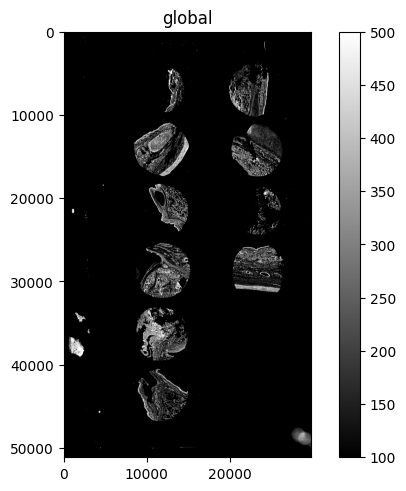

In [224]:
import spatialdata_plot
from matplotlib.colors import Normalize

vmax = 500
vmin = 100

norm = Normalize(vmax=vmax, vmin=vmin, clip=True)

sdata.pl.render_images(
    element = "scan",
    channel = "DAPI",
    scale = "scale3",
    cmap = "gray",
    norm = norm,
    ).pl.show()

region1


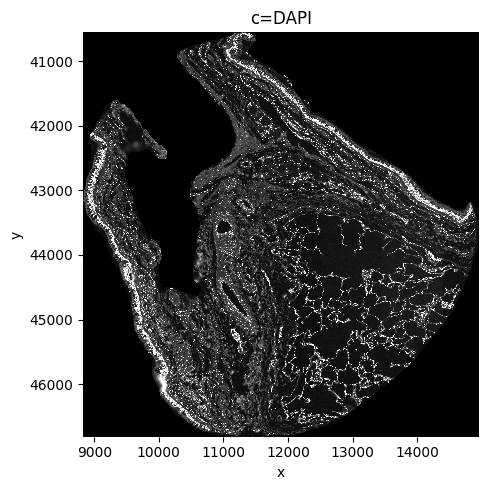

region2


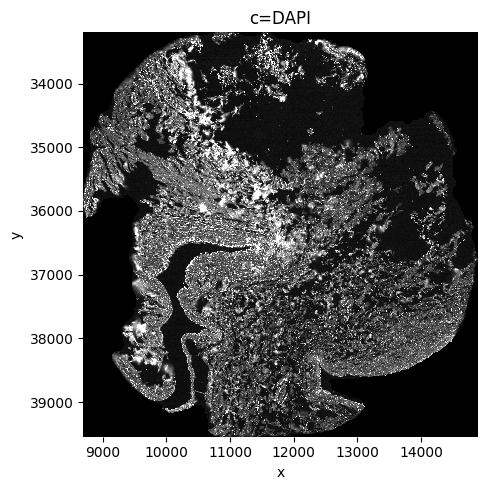

region3


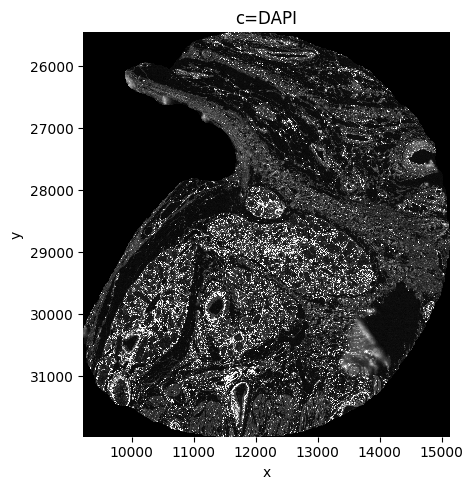

region4


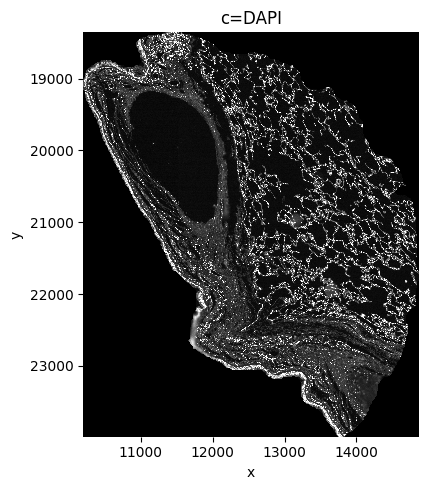

region5


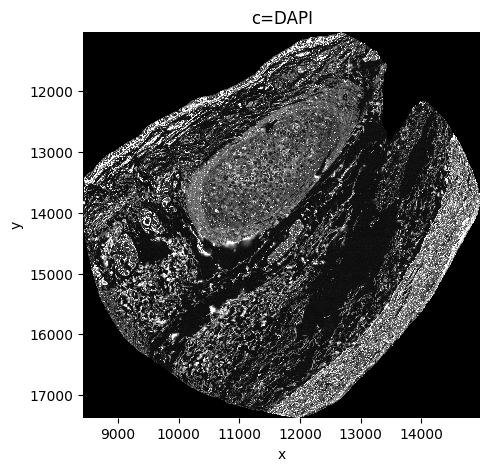

region6


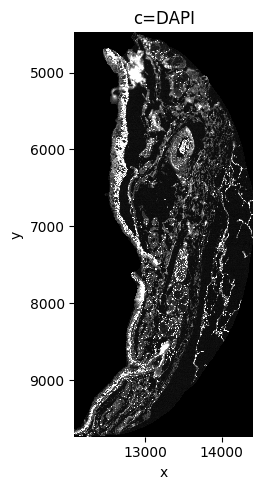

region7


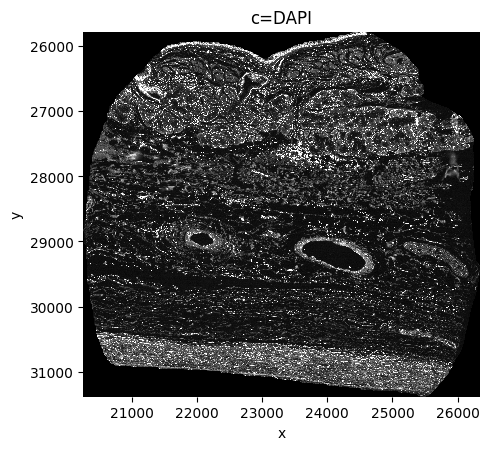

region8


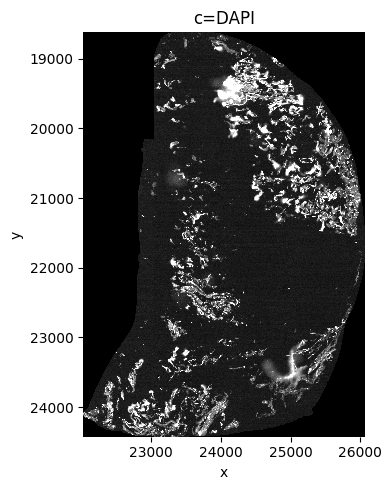

region9


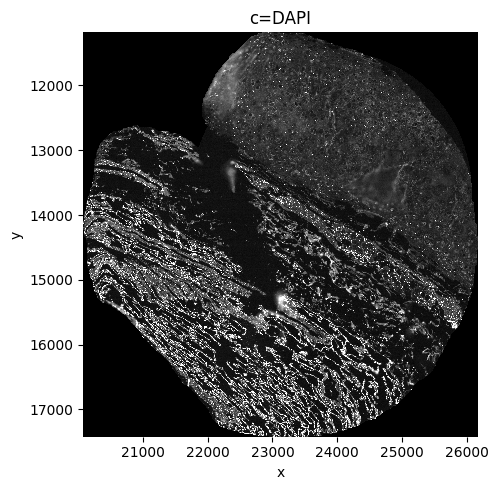

region10


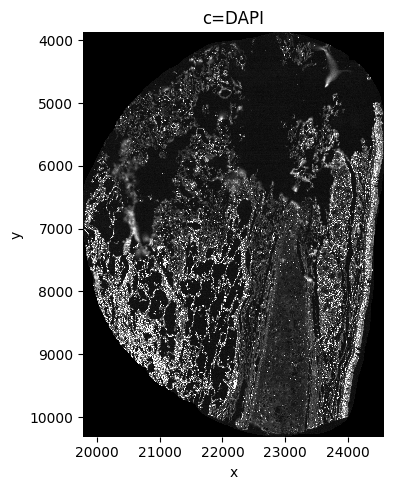

In [ ]:
# plot each region separately
for _tma_name in tma_name:
    print( _tma_name )
    hp.pl.plot_image(
        sdata,
        img_layer=f"scan_{_tma_name}",
        channel="DAPI",
        figsize=(5,5),
        to_coordinate_system=_tma_name,
          )

In [225]:
#from napari_spatialdata import Interactive

#Interactive( sdata )

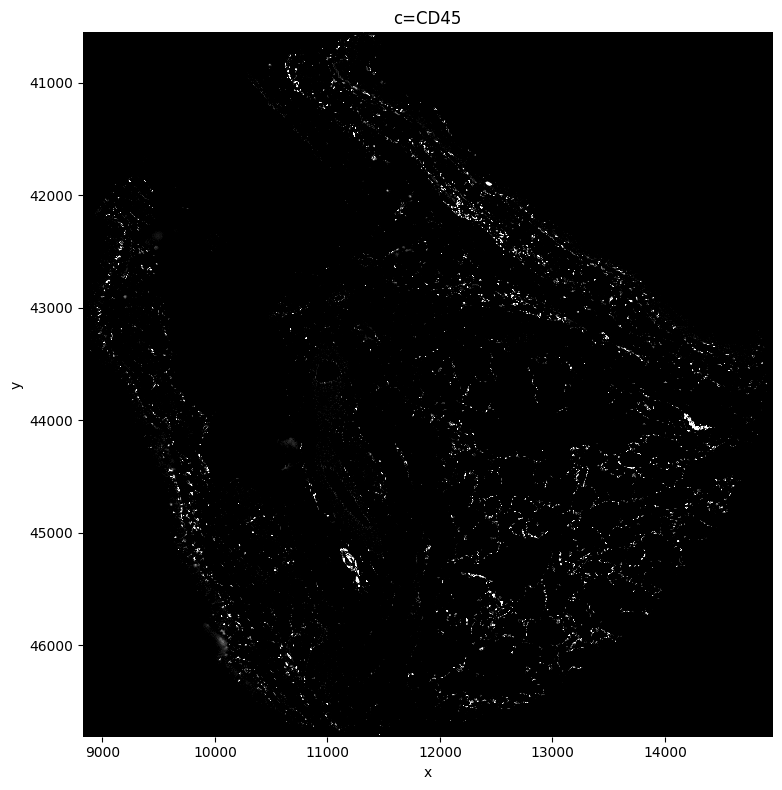

In [36]:
hp.pl.plot_image(
    sdata,
    img_layer= "scan_region1",
    channel = "CD45",
    to_coordinate_system = "region1",
    vmin_img = 50,
    vmax_img = 1000,
    figsize = (8,8),
      )

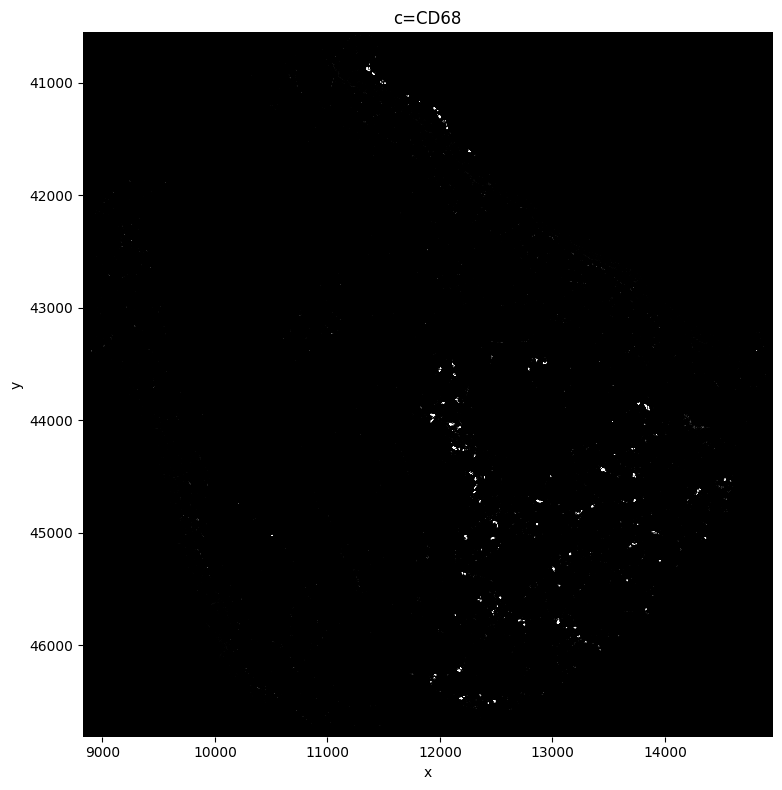

In [37]:
hp.pl.plot_image(
    sdata,
    img_layer= "scan_region1",
    channel = "CD68",
    to_coordinate_system = "region1",
    vmin_img = 50,
    vmax_img = 1000,
    figsize = (8,8),
      )

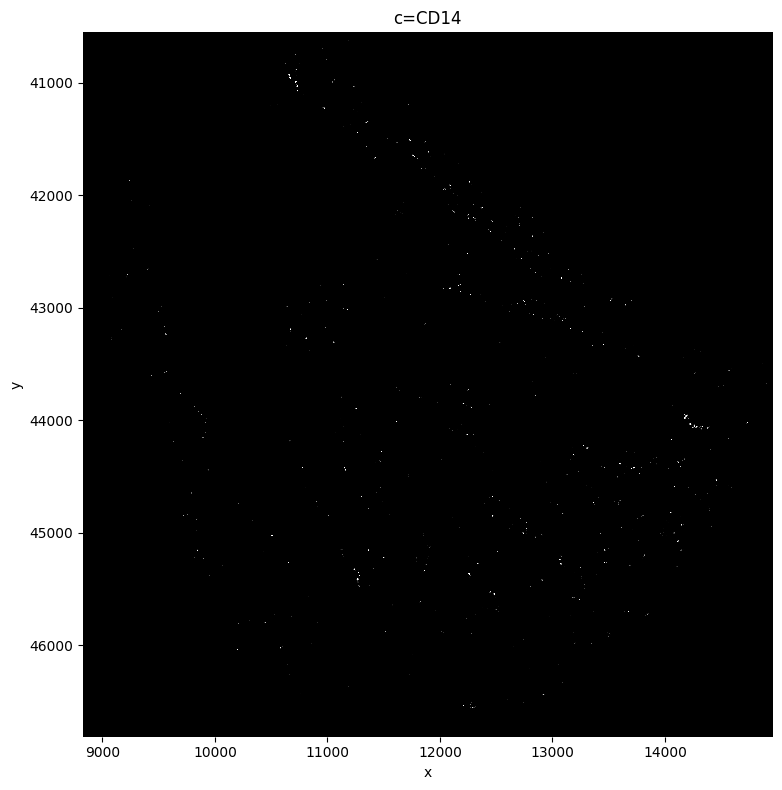

In [38]:
hp.pl.plot_image(
    sdata,
    img_layer = "scan_region1",
    channel = "CD14",
    to_coordinate_system = "region1",
    vmin_img = 200,
    vmax_img = 500,
    figsize = (8,8),
      )

In [45]:
import os
import requests
import zipfile
import tempfile

OUTPUT_DIR =  tempfile.gettempdir()

def download_and_unzip(url, extract_to):
    try:
        os.makedirs(extract_to, exist_ok=False)
    except FileExistsError:
        print("Model already downloaded.")
        return
    local_zip_path = os.path.join(extract_to, 'downloaded.zip')
    print("Downloading...")
    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(local_zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print("Unzipping...")
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    os.remove(local_zip_path)
    print(f"Done! Files extracted to: {extract_to}")

url = "https://github.com/instanseg/instanseg/releases/download/instanseg_models_v0.1.0/fluorescence_nuclei_and_cells.zip"
target_path = os.path.join(OUTPUT_DIR, "fluorescence_nuclei_and_cells" )
download_and_unzip(url, target_path)

Downloading...
Unzipping...
Done! Files extracted to: /var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/fluorescence_nuclei_and_cells


In [46]:
sdata[ "scan_region1" ].c.data

array(['DAPI', 'Ki67', 'Pan-Cytokeratin', 'CD68', 'CD14', 'CD20', 'CD4',
       'CD8', 'CD31', 'CD3e', 'Col1A1', 'SMA', 'HLA-DR', 'SFTPC', 'CXCL4',
       'CD45', 'ATP1A1', 'LYVE1', 'FOXP3', 'TPSAB1', 'AGER', 'CD11c',
       'CD163', 'Keratin 5', 'Collagen IV', 'MPO', 'SCEL', 'CD1c',
       'TUBB3', 'SCGB1A1', 'TP63', 'E-cadherin', 'MUC5AC', 'FOXJ1',
       'Keratin-14', 'SCGB3A2', 'CD55', 'PROX1', 'SFTPB', 'GRP',
       'Podoplanin', 'MUC5B', 'Caveolin', 'SOX2', 'KRT8', 'SOX9'],
      dtype='<U15')

In [47]:
#sdata[ "scan_region1" ].c.data.tolist()
labels = [ "DAPI", "CD45", "CD68", "CD14" ]

array_channels = sdata[ "scan_region1" ].c.data
label_to_index = {label: idx for idx, label in enumerate(array_channels)}
indices = [label_to_index[label] for label in labels]

In [48]:
from spatialdata.transformations import get_transformation

transformations = get_transformation( sdata[ "scan_region1" ], get_all=True )

sdata = hp.im.add_image_layer(
    sdata,
    arr = sdata[ "scan_region1" ].data[ indices ],
    output_layer = "scan_region1_subset",
    transformations=transformations,
    c_coords = labels,
    overwrite=True,
)

2025-04-28 09:36:33,571 - harpy.image._manager - INFO - Writing results to layer 'scan_region1_subset'
2025-04-28 09:36:35,181 - harpy.utils._io - WARNING - layer with name 'scan_region1_subset' already exists. Overwriting...


In [ ]:
import harpy as hp
import os

import torch
from instanseg import InstanSeg

path_model = os.path.join( target_path, "instanseg.pt" )

instanseg_fluorescence = torch.load( path_model, weights_only=False )
instanseg_fluorescence = InstanSeg( model_type=instanseg_fluorescence, device="cpu" )

crd_segment = [ 12000, 14000, 44000, 46000 ]

sdata = hp.im.segment(
    sdata,
    img_layer="scan_region1_subset",
    output_labels_layer=["labels_cells_instanseg"],
    output_shapes_layer=["shapes_cells_instanseg"],
    labels_layer_align=None,
    depth=50,
    model=hp.im.instanseg_callable,
    # parameters passed to hp.im.instanseg_callable
    output="cells",
    device="cpu",
    instanseg_model=path_model,  # load it in every worker, because torchscript model is not serializable
    iou=True,
    trim=False,
    crd=crd_segment,
    to_coordinate_system="region1",
    overwrite=True,
)

2025-04-28 09:37:18,958 - harpy.image.segmentation._segmentation - INFO - Linking labels across chunks.
2025-04-28 09:37:18,966 - harpy.image._manager - INFO - Writing results to layer 'labels_cells_instanseg'
2025-04-28 09:37:19,394 - harpy.utils._io - WARNING - layer with name 'labels_cells_instanseg' already exists. Overwriting...
2025-04-28 09:37:19,964 - harpy.shape._manager - INFO - Finished vectorizing. Dissolving shapes at the border of the chunks. This can take a couple minutes if input mask contains a lot of chunks.
2025-04-28 09:37:20,035 - harpy.shape._manager - INFO - Dissolve is done.
2025-04-28 09:37:20,343 - harpy.utils._io - WARNING - layer with name 'shapes_cells_instanseg' already exists. Overwriting...


In [50]:
labels = [ "DAPI", "CD45", "CD68", "CD14" ]

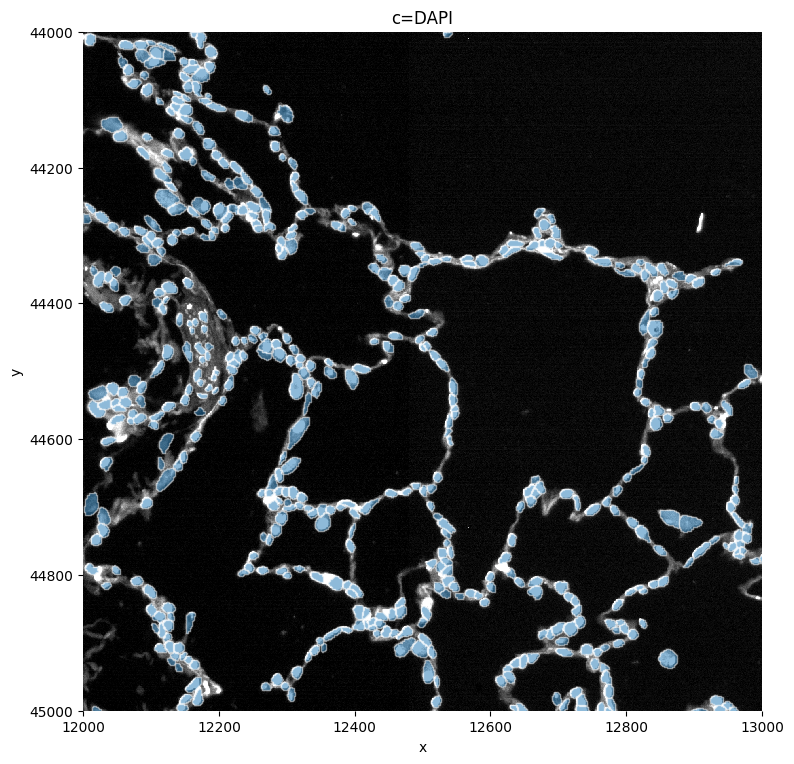

In [51]:
hp.pl.plot_shapes(
    sdata,
    img_layer= "scan_region1",
    shapes_layer = "shapes_cells_instanseg",
    channel="DAPI",
    to_coordinate_system="region1",
    vmin_img = 50,
    vmax_img = 500,
    alpha=0.5,
    crd = [12000, 13000, 44000, 45000 ],
    figsize = (8,8),
      )

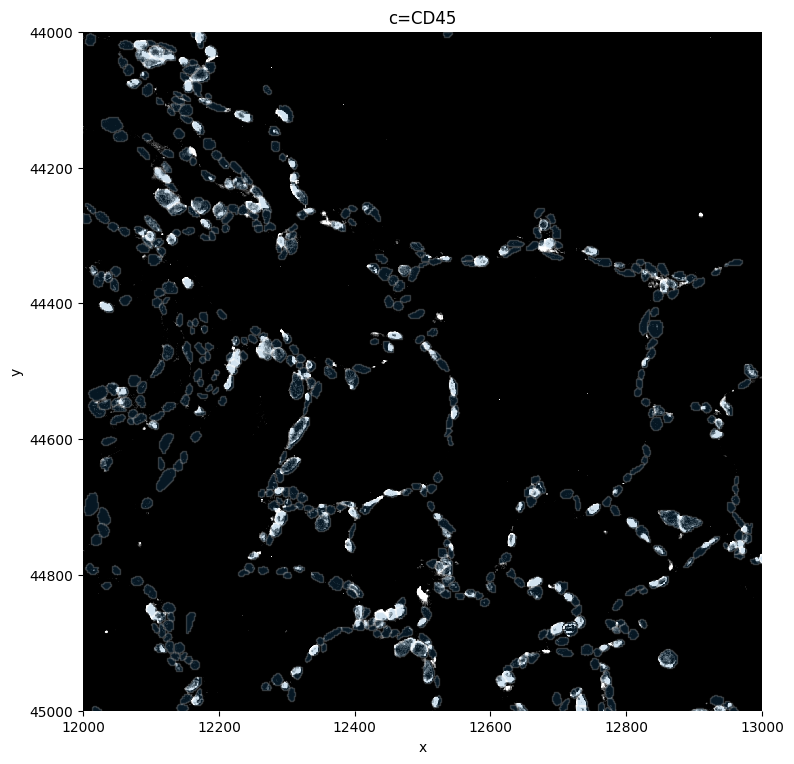

In [52]:
hp.pl.plot_shapes(
    sdata,
    img_layer = "scan_region1",
    shapes_layer = "shapes_cells_instanseg",
    channel = "CD45",
    to_coordinate_system = "region1",
    vmin_img = 50,
    vmax_img = 500,
    alpha=0.2,
    crd = [12000, 13000, 44000, 45000 ],
    figsize = (8,8),
      )

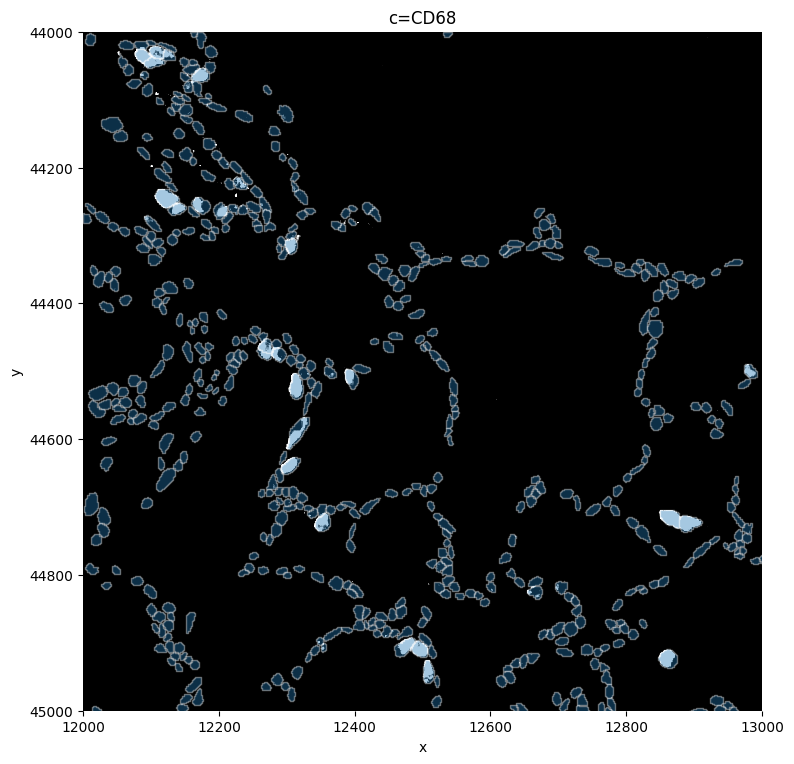

In [53]:
hp.pl.plot_shapes(
    sdata,
    img_layer= "scan_region1",
    shapes_layer = "shapes_cells_instanseg",
    channel = "CD68",
    to_coordinate_system = "region1",
    vmin_img = 200,
    vmax_img = 500,
    alpha=0.4,
    crd = [12000, 13000, 44000, 45000 ],
    figsize = (8,8),
      )

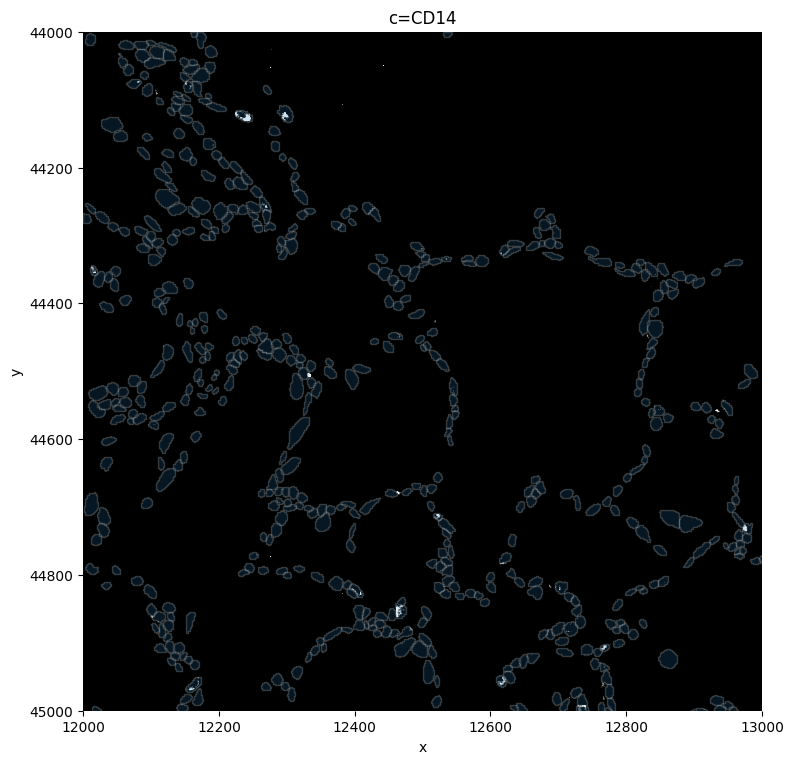

In [54]:
hp.pl.plot_shapes(
    sdata,
    img_layer= "scan_region1",
    shapes_layer = "shapes_cells_instanseg",
    channel="CD14",
    to_coordinate_system="region1",
    vmin_img = 200,
    vmax_img = 500,
    alpha=0.2,
    crd = [12000, 13000, 44000, 45000 ],
    figsize = (8,8),
      )

In [146]:
#from spatialdata import read_zarr
#sdata = read_zarr( sdata.path )

In [162]:
# we want to extract all channels

from spatialdata.transformations import get_transformation
from spatialdata.transformations import Translation

transformations = get_transformation( sdata[ "scan_region1" ], get_all=True )
y_translation=transformations[ "region1" ].to_affine_matrix( input_axes=("y", "x" ), output_axes=( "y", "x" ) )[ 0, 2 ]
x_translation=transformations[ "region1" ].to_affine_matrix( input_axes=("y", "x" ), output_axes=( "y", "x" ) )[ 1, 2 ]

array=sdata[ "scan_region1" ].data[ :, crd_segment[ 2 ]-y_translation: crd_segment[3]-y_translation, crd_segment[0]-x_translation: crd_segment[1]-x_translation ]

sdata = hp.im.add_image_layer(
    sdata,
    arr=array.rechunk( 2048 ),
    output_layer="scan_region1_crop",
    transformations={ "region1": Translation( axes = ( "y", "x" ), translation=[ 44000, 12000 ] ) },
    c_coords=sdata[ "scan_region1" ].c.data,
    overwrite=True,
 )

2025-04-28 11:52:45,389 - harpy.image._manager - INFO - Writing results to layer 'scan_region1_crop'
2025-04-28 11:52:46,587 - harpy.utils._io - WARNING - layer with name 'scan_region1_crop' already exists. Overwriting...


In [194]:
channels = sdata[ "scan_region1_crop" ].c.data
channels = channels[ channels!="DAPI" ]
channels

array(['Ki67', 'Pan-Cytokeratin', 'CD68', 'CD14', 'CD20', 'CD4', 'CD8',
       'CD31', 'CD3e', 'Col1A1', 'SMA', 'HLA-DR', 'SFTPC', 'CXCL4',
       'CD45', 'ATP1A1', 'LYVE1', 'FOXP3', 'TPSAB1', 'AGER', 'CD11c',
       'CD163', 'Keratin 5', 'Collagen IV', 'MPO', 'SCEL', 'CD1c',
       'TUBB3', 'SCGB1A1', 'TP63', 'E-cadherin', 'MUC5AC', 'FOXJ1',
       'Keratin-14', 'SCGB3A2', 'CD55', 'PROX1', 'SFTPB', 'GRP',
       'Podoplanin', 'MUC5B', 'Caveolin', 'SOX2', 'KRT8', 'SOX9'],
      dtype='<U15')

In [208]:
sdata = hp.tb.allocate_intensity( 
    sdata,
    img_layer= "scan_region1_crop",
    labels_layer="labels_cells_instanseg",
    output_layer="table_intensities",
    channels=channels,
    mode= "sum",
    to_coordinate_system="region1",
    overwrite=True,
        )

2025-04-28 12:15:03,392 - harpy.utils._io - WARNING - layer with name 'table_intensities' already exists. Overwriting...


In [209]:
sdata[ "table_intensities" ].to_df().head()

channels                              Ki67  Pan-Cytokeratin    CD68    CD14  \
cells                                                                         
21_labels_cells_instanseg_b0e32830   253.0           1543.0   786.0   352.0   
22_labels_cells_instanseg_b0e32830    91.0            297.0   310.0   115.0   
23_labels_cells_instanseg_b0e32830  1930.0            635.0  3101.0  2799.0   
24_labels_cells_instanseg_b0e32830   187.0            235.0   863.0    22.0   
25_labels_cells_instanseg_b0e32830   464.0            677.0   486.0  8729.0   

channels                               CD20     CD4      CD8     CD31    CD3e  \
cells                                                                           
21_labels_cells_instanseg_b0e32830     66.0   165.0    116.0    112.0   724.0   
22_labels_cells_instanseg_b0e32830      1.0   299.0      4.0      3.0   205.0   
23_labels_cells_instanseg_b0e32830    323.0  2249.0    643.0   6156.0  2651.0   
24_labels_cells_instanseg_b0e32830    117.0   104.0      0.0    956.0    87.0   
25_labels_cells_instanseg_b0e32830  16180.0  8761.0  16942.0  16668.0  6254.0   

channels                              Col1A1  ...     CD55  PROX1  SFTPB  \
cells                                         ...                          
21_labels_cells_instanseg_b0e32830   11864.0  ...   4816.0  137.0   15.0   
22_labels_cells_instanseg_b0e32830   66678.0  ...   1269.0    0.0   21.0   
23_labels_cells_instanseg_b0e32830   12765.0  ...   3722.0  108.0   79.0   
24_labels_cells_instanseg_b0e32830       0.0  ...   4507.0  232.0   40.0   
25_labels_cells_instanseg_b0e32830  133146.0  ...  28222.0  264.0  251.0   

channels                               GRP  Podoplanin  MUC5B  Caveolin  \
cells                                                                     
21_labels_cells_instanseg_b0e32830   157.0        84.0  538.0    1782.0   
22_labels_cells_instanseg_b0e32830   266.0        16.0  149.0     208.0   
23_labels_cells_instanseg_b0e32830  3583.0       549.0  155.0   57354.0   
24_labels_cells_instanseg_b0e32830  4694.0        55.0   33.0    7346.0   
25_labels_cells_instanseg_b0e32830   706.0       355.0  436.0    1199.0   

channels                              SOX2   KRT8    SOX9  
cells                                                      
21_labels_cells_instanseg_b0e32830   449.0  248.0   465.0  
22_labels_cells_instanseg_b0e32830   177.0  109.0   145.0  
23_labels_cells_instanseg_b0e32830  3089.0  639.0  4696.0  
24_labels_cells_instanseg_b0e32830  1972.0  176.0   860.0  
25_labels_cells_instanseg_b0e32830   943.0  427.0   798.0  

[5 rows x 45 columns]

In [211]:
sdata=hp.tb.preprocess_proteomics(
    sdata,
    labels_layer="labels_cells_instanseg",
    table_layer="table_intensities",
    output_layer="table_intensities_prepocessed",
    size_norm=True,
    overwrite=True,
      )

2025-04-28 12:27:18,220 - harpy.table._preprocess - INFO - Calculating cell size from provided labels_layer 'labels_cells_instanseg'
2025-04-28 12:27:18,776 - harpy.utils._io - WARNING - layer with name 'table_intensities_prepocessed' already exists. Overwriting...


2025-04-28 13:07:07,021 - harpy.utils._io - WARNING - layer with name 'table_intensities_leiden' already exists. Overwriting...


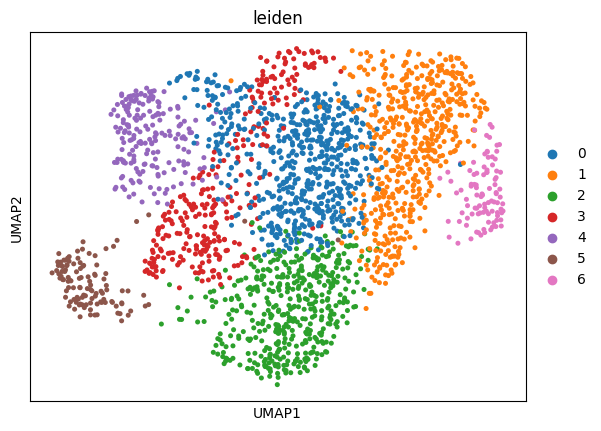

In [218]:
import scanpy as sc

# Leiden clustering
sdata = hp.tb.leiden(
    sdata,
    labels_layer="labels_cells_instanseg",
    table_layer="table_intensities_prepocessed",
    output_layer="table_intensities_leiden",
    calculate_umap=True,
    calculate_neighbors=True,
    n_pcs=17, # The number of principal components to use when calculating neighbors.
    n_neighbors=35, # The number of neighbors to consider when calculating neighbors.
    resolution=0.4,
    rank_genes=True,
    key_added="leiden",
    overwrite=True,
)

# Plot UMAP
sc.pl.umap(sdata.tables["table_intensities_leiden"], color=["leiden"], show=True)

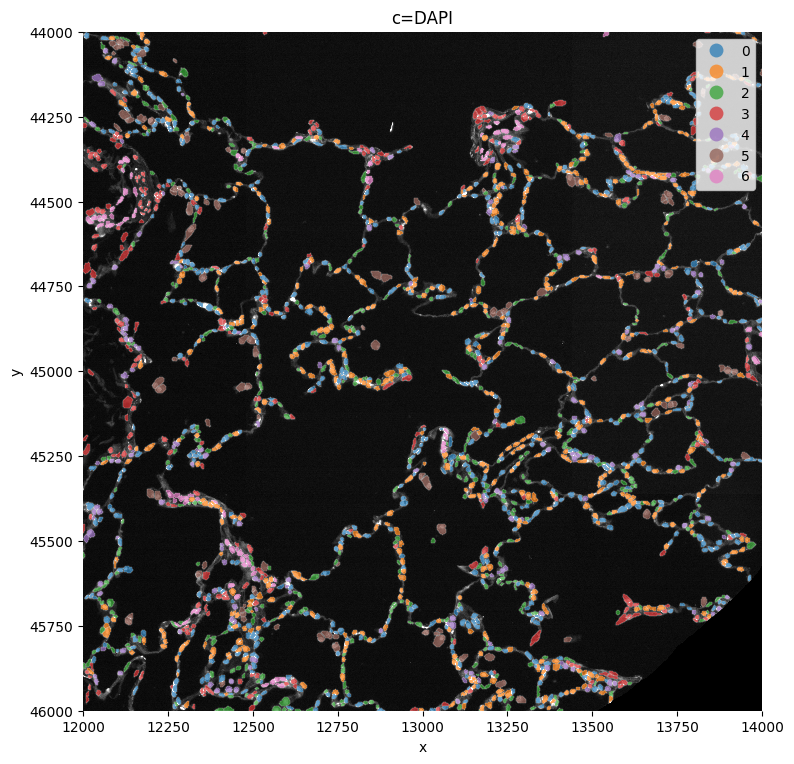

In [219]:
hp.pl.plot_shapes( 
    sdata,
    img_layer="scan_region1_crop",
    table_layer="table_intensities_leiden",
    shapes_layer="shapes_cells_instanseg",
    column="leiden",
    channel="DAPI",
    linewidth=0.2,
    alpha=0.7,
    figsize=( 8,8 ),
    to_coordinate_system="region1",
 )

In [242]:
#from napari_spatialdata import Interactive

#Interactive( sdata )